# Variational AutoEncoder with MNIST

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [3]:
# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST Data

In [4]:
batch_size = 128
test_batch_size = 5

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=True,
                            transform=transform,
                            download=True)

test_data  = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=False,
                            transform=transform,
                            download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader  = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=test_batch_size,
                                           shuffle=False)

len(train_data)

60000

## Define Model

In [6]:
latent_size = 20

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU()
        )

        # mean vector
        self.f_mu = nn.Sequential(
            nn.Linear(400, latent_size),
            nn.ReLU()
        )
        
        # standard deviation vector
        self.f_std = nn.Sequential(
            nn.Linear(400, latent_size),
            nn.ReLU()
        )               
        
    def encode(self, x) :
        out = self.encoder(x)
        
        mu = self.f_mu(out)
        log_std = self.f_std(out)
        
        return mu, log_std
        
    def f_reparametrize(self, mu, log_std) :
        if self.training :
            std = (log_std * 0.5).exp()

            # random vector
            epsilon = torch.randn(std.size()).to(device)

            # z vector
            z = mu + std * epsilon

            return z
        else :
            return mu
        
    def forward(self, x):
        # x --> mu, std
        mu, log_std = self.encode(x)
        
        # mu, std --> z
        z = self.f_reparametrize(mu, log_std)
        
        return mu, log_std, z

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_size, 400),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        out = self.fc(z)
        out = self.decoder(out)
        
        return out

In [9]:
E = Encoder().to(device)
D = Decoder().to(device)

In [10]:
recon_loss = nn.BCELoss(reduction='sum')
# recon_loss = nn.MSELoss()

def vae_loss(recon_X, X, mu, log_std) :
    r_loss = recon_loss(recon_X, X)   
    
    k_loss = -0.5 * torch.sum(1 + log_std - mu.pow(2) - log_std.exp())
    k_loss /= batch_size * 784
    
    total_loss = r_loss + k_loss
    
    return r_loss, k_loss, total_loss

In [11]:
# Encoder + Decoder 함께 학습
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

## Training

In [12]:
num_epochs = 30

for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size

    R_loss = 0
    K_loss = 0
    total_loss = 0

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.to(device)
        X = X.view(-1,28*28)
        
        mu, log_std, z = E(X)
        pred = D(z)
        
        r_loss, k_loss, cost = vae_loss(pred, X, mu, log_std)
        
        R_loss += r_loss.item()
        K_loss += k_loss.item()
        total_loss += cost.item()
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    print('Epoch %d/%d, Loss: %.5f (Recon: %.5f | KLD: %.5f)'%
          (epoch+1, num_epochs, total_loss/total_batch, R_loss/total_batch, K_loss/total_batch))

Epoch 1/30, Loss: -2901155.39162 (Recon: -2903228.69851 | KLD: 2073.30481)
Epoch 2/30, Loss: -3898277.21848 (Recon: -3898366.56838 | KLD: 89.34757)
Epoch 3/30, Loss: -3691677.29380 (Recon: -3691685.44124 | KLD: 8.14872)
Epoch 4/30, Loss: -3727265.92041 (Recon: -3727280.66987 | KLD: 14.75073)
Epoch 5/30, Loss: -3614219.46421 (Recon: -3614241.59882 | KLD: 22.13735)
Epoch 6/30, Loss: -3544921.57265 (Recon: -3544949.43857 | KLD: 27.86668)
Epoch 7/30, Loss: -3470251.17147 (Recon: -3470283.59882 | KLD: 32.43024)
Epoch 8/30, Loss: -3396971.22810 (Recon: -3397007.08868 | KLD: 35.86246)
Epoch 9/30, Loss: -3338472.02511 (Recon: -3338510.57692 | KLD: 38.54779)
Epoch 10/30, Loss: -3204564.77030 (Recon: -3204606.14637 | KLD: 41.38123)
Epoch 11/30, Loss: -3148668.77244 (Recon: -3148712.59455 | KLD: 43.82338)
Epoch 12/30, Loss: -3089126.05502 (Recon: -3089172.08600 | KLD: 46.03031)
Epoch 13/30, Loss: -3047476.08814 (Recon: -3047523.71581 | KLD: 47.62996)
Epoch 14/30, Loss: -2989417.51656 (Recon: -298

## Generate images

In [13]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

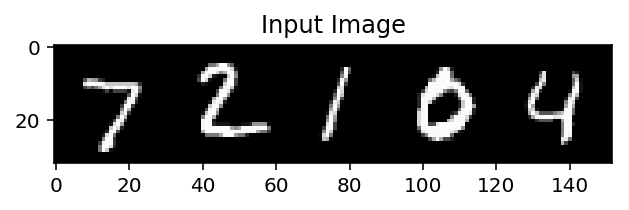

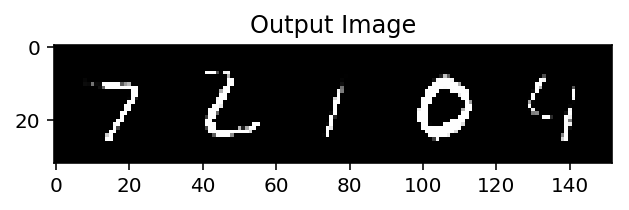

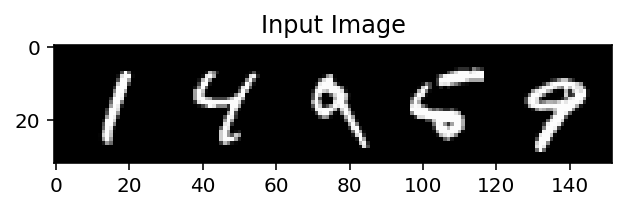

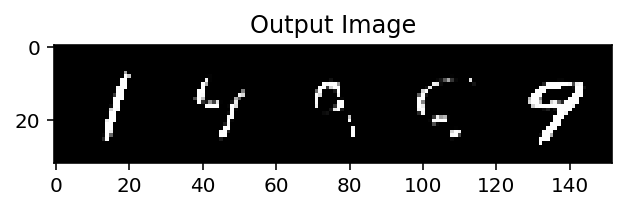

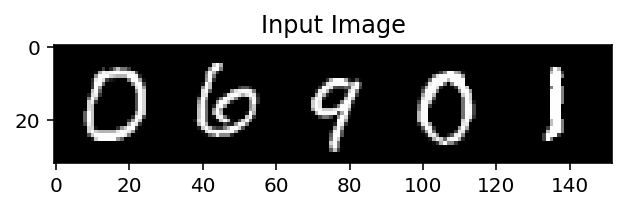

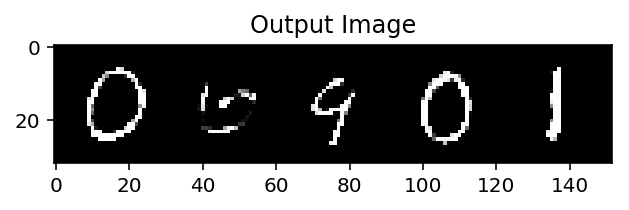

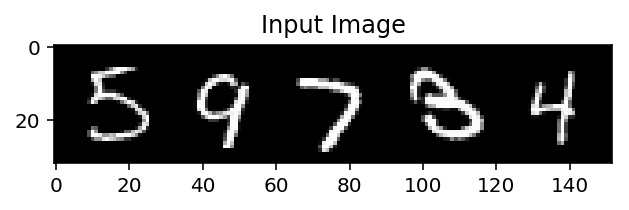

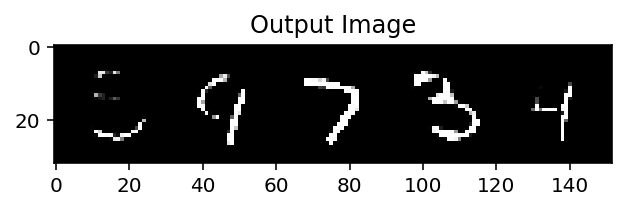

In [14]:
E.eval()
D.eval()

for i, (images, labels) in enumerate(test_loader):
    
    imshow(utils.make_grid(images, normalize=True), "Input Image")
    images  = images.view(test_batch_size, 1, 28*28).to(device)
    
    mu, log_std, z = E(images)
    outputs = D(z)
    outputs = outputs.view(test_batch_size, 1, 28, 28)
    
    imshow(utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    print('=========================================')
    
    if i > 2 : break